# Segmentation de la dentine
## Partie 1: Chargement des données et visualisation en 2D et en 3D

### 1- Configuration de  l'environnement de travail

In [1]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.widgets import Button, Slider
import skimage as ski
import cv2
import scipy.ndimage as nd
from tifffile import imread
import tifffile
import stackview
import imageio.v3 as iio

### 2- Chargement des images

In [5]:
# Charger les images en 3D
stack_3d = imread("/home/experiences/grades/saras/Documents/DATA_SWING/01_processed_data/tomo_sain61_si_dej_S00017_to_S00504_480x480_gpu_1modes_200DM500ML_recons_S/00_stack_3d/03_crop_data.tif)
OUPUT = "/home/experiences/grades/saras/Documents/DATA_SWING/01_processed_data/tomo_sain61_si_dej_S00017_to_S00504_480x480_gpu_1modes_200DM500ML_recons_S/01_3D_Watershed_Segmentation/

In [6]:
# reshape
stack_3d = np.transpose(stack_3d, (1,2,0))

In [7]:
# Créer un array vide pour la boucle
image_3d = np.zeros_like(stack_3d)
print(image_3d.shape)
borderlow_3d = np.zeros_like(stack_3d)
print(borderlow_3d.shape)

(864, 864, 832)
(864, 864, 832)


In [8]:
# boucle en 3d
for i in range(stack_3d.shape[2]):
    img = stack_3d[:,:,i]
    border = ski.filters.threshold_yen(img)
    border = img > border
    border = ski.morphology.remove_small_objects(border)
    borderfill = ski.morphology.area_closing(border, area_threshold=10000)
    borderlow = ski.morphology.isotropic_erosion(borderfill, 25)
    imclean = img.copy()
    imclean[~borderlow] = 0

    # image_vide
    image_vide = np.zeros_like(imclean)

    #Watershed
    #Seuil
    seuil_1 = 35000
    seuil_2 = 0
    seuil_3 = 30500
    # Masque binaire avec les pixels [seuil_2 _ seuil2)]
    masque = (imclean > seuil_2) & (imclean < seuil_3)

    # remplissage de l'array avec les seuils
    image_vide[masque] = 2
    image_vide[imclean > seuil_1] = 1
    image_vide[~borderlow] = 0

    image_3d[:,:,i] = image_vide
    borderlow_3d[:,:,i] = borderlow

KeyboardInterrupt: 

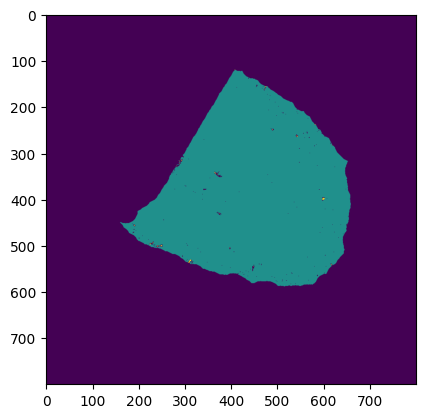

In [6]:
plt.imshow(image_3d[:,:,0])
plt.show()

## Partie 3-  Watershed pour la segmentation de la lumière tubulaire

### 3- Watershed transformation

In [ ]:
# Watershed
elem = ski.morphology.disk(5)
watershed_labels = ski.segmentation.watershed(ski.filters.sobel(ski.filters.gaussian(stack_3d,1)), image_3d)

In [7]:
# Création des labels à partir du watershed
watershed_labels[watershed_labels == 1] = 0
watershed_labels[watershed_labels == 2] = 1

lumiere = borderlow_3d & watershed_labels

## Partie 3-  Visualisation du résultats 

### Superposition entre masque lumière tubulaire et image d'origine

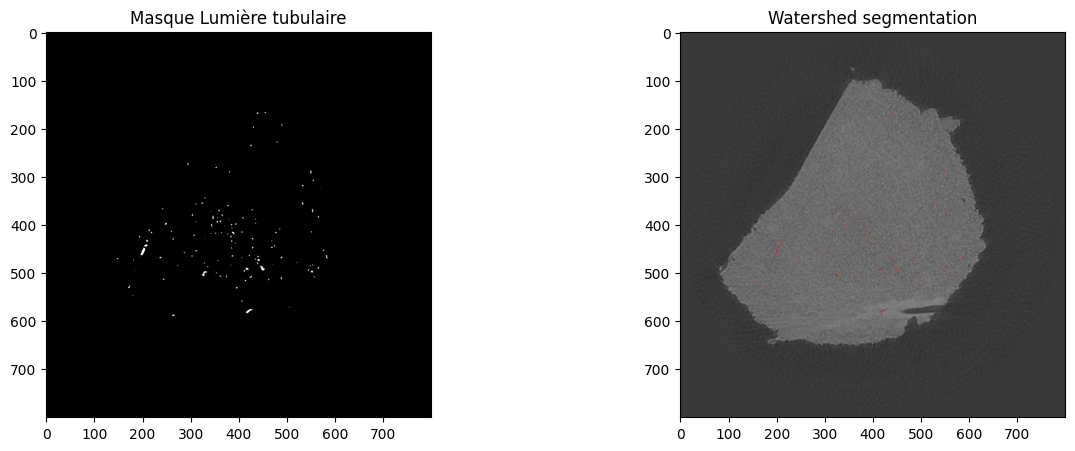

In [94]:
# Superposition
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].imshow(lumiere, cmap="gray")
ax[0].set_title("Masque Lumière tubulaire")
ax[1].imshow(ski.color.label2rgb(lumiere, im_array), cmap="gray")
ax[1].set_title("Watershed segmentation")
plt.show()
